Data Download Instructions: 

Download zip file from https://www.upjohn.org/data-tools/employment-research-data-center/pennsylvania-reemployment-bonus-demonstration. 

After downloading zip file, turn the recsfile.dta file into a csv file, and put it under data/ 

In [1]:
import numpy as np
import os
import torch 
import pandas as pd

os.chdir("../..")

from aexgym.model import PersonalizedLinearModel
from aexgym.agent import LinearTS, LinearUniform, LinearUCB
from aexgym.objectives import contextual_best_arm, contextual_simple_regret
from notebooks.pennui.penn_env import PennEnv
from notebooks.pennui.process_penn import process_penn
from scripts.setup_script import make_uniform_prior

In [2]:
PATH = "data/penn.csv"
df = process_penn(PATH, outcome=1, linear_impute=True)

df

,const,black,hispanic,othrace,dem_inel,tg,revasamp,sex,dep,sep,...,bp_flag,noh_sub,bv_sub,t0_predict,t1_predict,t2_predict,t3_predict,t4_predict,t5_predict,t6_predict
0,1.0,0.0,0.0,0.0,1.0,-1.278358,1.0,-0.814187,2.031344,1.851466,...,0.0,0.0,0.0,-18.000000,-18.817135,-15.235343,-14.399216,-15.064193,-18.039120,-17.617310
1,1.0,0.0,0.0,0.0,1.0,-0.283591,1.0,-0.814187,-0.592753,-0.932172,...,0.0,0.0,0.0,-5.306687,-6.660899,-7.000000,-4.652355,-6.958733,-6.868495,-6.597053
2,1.0,0.0,0.0,0.0,1.0,1.208560,1.0,1.228220,-0.592753,-0.468232,...,0.0,0.0,0.0,-18.479162,-17.804611,-18.622503,-19.790600,-18.382006,-18.000000,-19.487572
3,1.0,0.0,0.0,0.0,1.0,-1.278358,1.0,-0.814187,-0.592753,-0.468232,...,0.0,0.0,0.0,-1.000000,-1.508429,-1.382615,-3.392883,-1.653552,-1.798510,-1.534848
4,1.0,0.0,0.0,0.0,1.0,-1.278358,1.0,-0.814187,-0.592753,1.851466,...,0.0,0.0,0.0,-27.000000,-25.146425,-21.264933,-21.521952,-22.321020,-26.038406,-24.703938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17506,1.0,0.0,0.0,0.0,1.0,1.208560,1.0,-0.814187,-0.592753,-0.468232,...,0.0,0.0,0.0,-24.504032,-22.007193,-25.183683,-27.522308,-26.855114,-27.000000,-24.880016
17507,1.0,0.0,0.0,0.0,1.0,-0.283591,1.0,1.228220,-0.592753,1.851466,...,0.0,0.0,0.0,-6.173014,-8.410195,-4.000000,-7.217371,-7.664505,-8.377069,-7.276390
17509,1.0,0.0,0.0,0.0,1.0,0.711176,1.0,-0.814187,-0.592753,-0.468232,...,0.0,1.0,0.0,-4.766527,-2.097654,-3.882164,-3.647294,-4.000000,-5.366132,-3.989274
17510,1.0,0.0,0.0,0.0,1.0,-1.278358,1.0,-0.814187,-0.592753,-0.932172,...,0.0,0.0,0.0,-27.000000,-27.149408,-23.003874,-22.327446,-24.355072,-26.390579,-23.277111


In [3]:
n_days = 6
n_arms = 7
context_len = df.shape[1] - 7 #83
n_steps = n_days 
batch_size = 7
s2 = 0.1 * torch.ones((n_days, 1))

if torch.cuda.is_available():
    device = 'cpu'#'cuda:0'
else:
    device = 'cpu'
print(device)

cpu


In [4]:
#personalization 

#initialize MDPs
n_objs = 1
scaling = 1 / (batch_size*10)
pers_beta, pers_sigma = make_uniform_prior(context_len*n_arms, scaling, n_objs=n_objs)

model = PersonalizedLinearModel(
    beta_0 = pers_beta, 
    sigma_0 = pers_sigma, 
    n_arms = n_arms, 
    s2 = s2, 
    n_objs = n_objs,
    use_precision=True
)
env = PennEnv(df, batch_size, n_days)

In [5]:
#agent = LinearUniform(model, "Linear Uniform")
#agent = LinearTS(model, "Linear TS", toptwo=False, n_samples = 1)
#agent = LinearTS(model, "Linear TS toptwo", toptwo=True, n_samples = 100)
agent = LinearUCB(model, "Linear UCB", alpha = 0.95)


In [6]:
#set seed and experiment parameters 
from aexgym.objectives.regret import constraint_best_arm, multi_obj_best_arm


torch.manual_seed(0)
torch.set_printoptions(sci_mode=False) 
print_probs = False

#set objective 
objective = contextual_best_arm() #contextual_simple_regret()

#initialize lists
regret_list = []
percent_arms_correct_list = []

#run experiment simulation
for i in range(10000):
    env.reset()
    #print(env.mean_matrix)
    all_contexts, cur_step = env.reset()
    beta, sigma = agent.model.reset()
    #print(beta, sigma)
    beta, sigma = beta.to(device), sigma.to(device)
    beta_0, sigma_0 = beta.clone(), sigma.clone()
    
    while env.n_steps - cur_step > 0:

        #move to device 
        state_contexts, action_contexts, eval_contexts = tuple(contexts.to(device) for contexts in all_contexts)
        
        #get probabilities
        probs = agent(
            beta = beta, 
            sigma = sigma, 
            contexts = state_contexts, 
            action_contexts = action_contexts, 
            objective = objective
        )
     
        #print probabilities 
        if print_probs == True:
            print(agent.name, env.n_steps - cur_step, torch.mean(probs, dim=0), end='\r')
        
        #get actions and move to new state
        actions = torch.distributions.Categorical(probs).sample()
        
        #move to next environment state 
        all_contexts, sampled_rewards, sampled_features, cur_step  = env.step(
            state_contexts = state_contexts, 
            action_contexts = action_contexts, 
            actions = actions
        )
        
        #update model state 
        beta, sigma = agent.model.update_posterior(
            beta = beta_0, 
            sigma = sigma_0, 
            rewards = sampled_rewards, 
            features = agent.model.feature_map(actions, state_contexts, action_contexts), 
            idx = cur_step-1
        )

    #get evaluation contexts and true rewards 
    eval_contexts = env.sample_eval_contexts(access=True).to(device)
    true_eval_rewards = env.get_true_rewards(eval_contexts, action_contexts)
    
    #calculate results from objective 
    results_dict = objective(
        fantasy_rewards = agent.fantasize(beta, eval_contexts, action_contexts).to(device), 
        true_rewards = true_eval_rewards.to(device)
    )
    
    #append results 
    percent_arms_correct_list.append(results_dict['percent_arms_correct'])
    regret_list.append(results_dict['regret'])

    #print results 
    if i % 10 == 0:
        
        print("Regret: ", np.mean(regret_list))
        print("Percent Arms Correct: ", np.mean(percent_arms_correct_list))

Regret:  2.694028854370117
Percent Arms Correct:  0.0
Regret:  1.2674692327325994
Percent Arms Correct:  0.09090909090909091
Regret:  1.5078785305931455
Percent Arms Correct:  0.047619047619047616
Regret:  1.6277148031419324
Percent Arms Correct:  0.06451612903225806
Regret:  1.5084045224073457
Percent Arms Correct:  0.12195121951219512
Regret:  1.5717000213323855
Percent Arms Correct:  0.11764705882352941
Regret:  1.5222081356361263
Percent Arms Correct:  0.11475409836065574
Regret:  1.5494325396040796
Percent Arms Correct:  0.1267605633802817
Regret:  1.4913371050799336
Percent Arms Correct:  0.12345679012345678
Regret:  1.4571123647165822
Percent Arms Correct:  0.13186813186813187
Regret:  1.47107466140596
Percent Arms Correct:  0.13861386138613863
Regret:  1.4777501638945159
Percent Arms Correct:  0.14414414414414414
Regret:  1.4790156616652308
Percent Arms Correct:  0.14049586776859505
Regret:  1.4729900614905904
Percent Arms Correct:  0.13740458015267176
Regret:  1.43897102910576

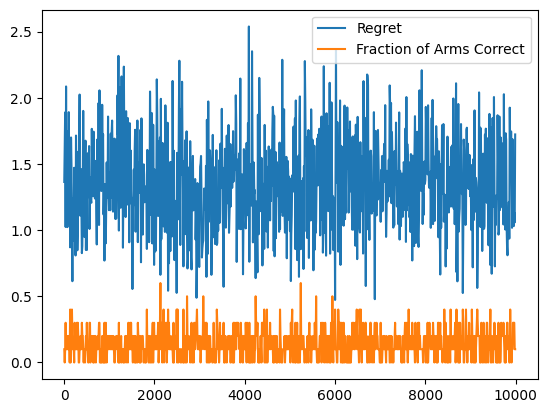

In [7]:
import matplotlib.pyplot as plt
regret_list_fmt = [np.average(regret_list[i:i+10]) for i in range(0, len(regret_list), 10)]
arms_correct_fmt = [np.average(percent_arms_correct_list[i:i+10]) for i in range(0, len(percent_arms_correct_list), 10)]

plt.plot(range(1, len(regret_list)+1, 10), regret_list_fmt, alpha = 1, label="Regret")
plt.plot(range(1, len(regret_list)+1, 10), arms_correct_fmt, alpha= 1, label="Fraction of Arms Correct")

plt.legend()
plt.show()

### Evaluation

This result demonstrates mode collapse. The model only predicts one of the 7 classes regardless of input. That is why the accuracy converges to 0.14, since we have 7 arms to choose from.